## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import os
import time
import json
from tqdm import tqdm
from datasets import load_dataset, concatenate_datasets

import seaborn as sns
import matplotlib.pyplot as plt

import config
from utils import *

os.environ['OPENAI_API_KEY'] = config.OPENAI_API_KEY

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import openai
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from repl.server import LeanServer, RobustLeanServer

## Stats and plots functions

In [3]:
def load_data(file_name = "baseline_direct_translation_gpt-4o_eval2"):
    json_file_path = '/home/agatha/Desktop/MA3/sem proj/autoformalization_with_hypothesis/results/evaluations/'+file_name+'.json'
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    return df

In [4]:
def avg_bleu_cossim(df):
    average_bleu = df['bleu'].mean()
    average_cosine_similarity = df['cosine_similarity'].mean()

    print(f"Average BLEU score: {average_bleu}")
    print(f"Average Cosine Similarity: {average_cosine_similarity}")

    df[['bleu', 'cosine_similarity']].hist(bins=20, figsize=(12, 6), layout=(1, 2), edgecolor='black')
    plt.show()

In [5]:
def num_repl_errors(df):
    df['num_repl_errors'] = df['repl_errors'].apply(len)


    plt.figure(figsize=(10, 6))
    plt.hist(df['num_repl_errors'], bins=range(0, 26), edgecolor='black')
    plt.xlabel('Number of REPL Errors')
    plt.ylabel('Frequency')
    plt.xlim(0, 10)

    plt.show()

In [6]:
def tc_bleu(df):
    df['num_repl_errors'] = df['repl_errors'].apply(len)
    df['TC-BLEU'] = df.apply(lambda row: 0 if row['num_repl_errors'] > 0 else row['bleu'], axis=1)

    average_tc_bleu = df['TC-BLEU'].mean()
    print(f"Average TC-BLEU score: {average_tc_bleu}")

    df['TC-BLEU'].hist(bins=20, edgecolor='black')
    plt.xlabel('TC-BLEU Score')
    plt.ylabel('Frequency')
    plt.show()

In [7]:
def stats(df):
    df['num_repl_errors'] = df['repl_errors'].apply(len)
    df['TC-BLEU'] = df.apply(lambda row: 0 if row['num_repl_errors'] > 0 else row['bleu'], axis=1)
    average_tc_bleu = df['TC-BLEU'].mean()

    repl_count = df['repl'].sum()
    beq_count = df['beq'].sum()
    N = len(df)

    repl_percentage = (repl_count / len(df)) * 100
    beq_percentage = (beq_count / len(df)) * 100

    print(f"Average TC-BLEU score: {average_tc_bleu:.3f}")
    print(f"Number of statements that type ckeck: {repl_count} / {N} : {repl_percentage:.2f}%")
    print(f"Number of equivalent (BEq) pairs: {beq_count} / {N} : {beq_percentage:.2f}%\n")

    

## heatmap of scores

In [23]:
def score(metric, experiment1, experiment2):
    """
    Computes the 'difference' score between two experiments for a given binary metric.
    
    Args:
        metric (str): The metric to compute the score for ('repl' or 'beq').
        experiment1 (str): Name of the first experiment file.
        experiment2 (str): Name of the second experiment file.
    
    Returns:
        float: The score reflecting how 'different' the results are between the two experiments.
    """
    # Load experiment data
    df1 = load_data(experiment1)
    df2 = load_data(experiment2)
    
    # Compute the metric column (repl or beq) if not already done
    if metric == 'repl':
        df1['num_repl_errors'] = df1['repl_errors'].apply(len)
        df1['repl'] = df1['num_repl_errors'].apply(lambda x: 1 if x == 0 else 0)
        df2['num_repl_errors'] = df2['repl_errors'].apply(len)
        df2['repl'] = df2['num_repl_errors'].apply(lambda x: 1 if x == 0 else 0)
    
    # Create sets of theorem names for the metric
    names1 = set(df1.loc[df1[metric] == 1, 'name'])
    names2 = set(df2.loc[df2[metric] == 1, 'name'])
    
    # Compute the unique and shared metrics
    unique1 = names1 - names2
    unique2 = names2 - names1
    shared = names1.intersection(names2)
    
    # Compute the score
    U12 = len(unique1)
    U21 = len(unique2)
    B = len(shared)
    
    score = (U12 - U21) / (U12 + U21 + B) if (U12 + U21 + B) > 0 else 0
    return score


In [16]:
def create_heatmap(metric, experiments):
    """
    Creates a heatmap of scores for all experiments compared to all experiments for a given metric.

    Args:
        metric (str): The metric to compute the score for ('repl' or 'beq').
        experiments (list of str): List of experiment names.

    Returns:
        None: Displays the heatmap.
    """
    # Define a mapping for custom experiment name changes
    name_mapping = {
        "baseline_direct_translation": "base_no_fewshot",
        "direct_translation_with_general_fewshot": "base",
        "base_hypothesis_decomp": "informal_hyp_decomp"
    }
    
    # Extract short names and apply custom mappings
    short_experiments = [
        name_mapping.get(exp.split('_gpt-4o-2024-11-20_eval2')[0], exp.split('_gpt-4o-2024-11-20_eval2')[0])
        for exp in experiments
    ]
    
    # Initialize an empty matrix to store scores
    n = len(experiments)
    score_matrix = np.zeros((n, n))
    
    # Compute scores for all pairs of experiments
    for i in range(n):
        for j in range(n):
            if i != j:  # Avoid computing for the same experiment
                score_matrix[i, j] = score(metric, experiments[i], experiments[j])
    
    # Create a DataFrame for the heatmap
    score_df = pd.DataFrame(score_matrix, index=short_experiments, columns=short_experiments)

    metric_title = "BEq" if metric == "beq" else "Type-Check"

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(score_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Score'})
    plt.title(f"Difference scores for metric: {metric}")
    plt.xlabel("Experiment 2")
    plt.ylabel("Experiment 1")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


## Comparison

In [26]:
experiments = [
    "baseline_direct_translation_gpt-4o-2024-11-20_eval2",
    "direct_translation_with_general_fewshot_gpt-4o-2024-11-20_eval2", 
    "base_hypothesis_decomp_gpt-4o-2024-11-20_eval2",
    "hyp_decomp_leansearch_gpt-4o-2024-11-20_eval2",
    "baseline_leansearch_top5_gpt-4o-2024-11-20_eval2",
    "baseline_leansearch_top3_gpt-4o-2024-11-20_eval2",
    "leandojo_top5_gpt-4o-2024-11-20_eval2",
    "leandojo_top3_gpt-4o-2024-11-20_eval2"
    ]

for experiment in experiments:
    print(f"Experiment: {experiment}")
    df = load_data(experiment)
    stats(df)

Experiment: baseline_direct_translation_gpt-4o-2024-11-20_eval2
Average TC-BLEU score: 0.177
Number of statements that type ckeck: 101 / 234 : 43.16%
Number of equivalent (BEq) pairs: 46 / 234 : 19.66%

Experiment: direct_translation_with_general_fewshot_gpt-4o-2024-11-20_eval2
Average TC-BLEU score: 0.195
Number of statements that type ckeck: 110 / 234 : 47.01%
Number of equivalent (BEq) pairs: 48 / 234 : 20.51%

Experiment: base_hypothesis_decomp_gpt-4o-2024-11-20_eval2
Average TC-BLEU score: 0.165
Number of statements that type ckeck: 89 / 234 : 38.03%
Number of equivalent (BEq) pairs: 45 / 234 : 19.23%

Experiment: hyp_decomp_leansearch_gpt-4o-2024-11-20_eval2
Average TC-BLEU score: 0.204
Number of statements that type ckeck: 123 / 234 : 52.56%
Number of equivalent (BEq) pairs: 52 / 234 : 22.22%

Experiment: baseline_leansearch_top5_gpt-4o-2024-11-20_eval2
Average TC-BLEU score: 0.202
Number of statements that type ckeck: 127 / 234 : 54.27%
Number of equivalent (BEq) pairs: 49 / 23

## Intersection of successes

In [18]:
# 1) Load the two experiments we want to compare
baseline_experiment = "direct_translation_with_general_fewshot_gpt-4o-2024-11-20_eval2"
leans_experiment    = "hyp_decomp_leansearch_gpt-4o-2024-11-20_eval2"

df_baseline = load_data(baseline_experiment)
df_leans    = load_data(leans_experiment)

# 2) Compute the 'repl' column from REPL errors if not already done
df_baseline['num_repl_errors'] = df_baseline['repl_errors'].apply(len)
df_baseline['repl'] = df_baseline['num_repl_errors'].apply(lambda x: 1 if x == 0 else 0)

df_leans['num_repl_errors'] = df_leans['repl_errors'].apply(len)
df_leans['repl'] = df_leans['num_repl_errors'].apply(lambda x: 1 if x == 0 else 0)

# 3) Create sets of theorem names for type-checking (repl=1)
baseline_tc_names = set(df_baseline.loc[df_baseline['repl'] == 1, 'name'])
leans_tc_names    = set(df_leans.loc[df_leans['repl'] == 1, 'name'])

intersection_tc   = baseline_tc_names.intersection(leans_tc_names)

print("Type-Check Stats:")
print(f"  Baseline only:   {len(baseline_tc_names - leans_tc_names)}")
print(f"  LeanSearch only: {len(leans_tc_names - baseline_tc_names)}")
print(f"  Both:            {len(intersection_tc)}")

# 4) Create sets of theorem names for equivalence (beq=1)
baseline_beq_names = set(df_baseline.loc[df_baseline['beq'] == 1, 'name'])
leans_beq_names    = set(df_leans.loc[df_leans['beq'] == 1, 'name'])

intersection_beq   = baseline_beq_names.intersection(leans_beq_names)

print("BEq Stats:")
print(f"  Baseline only:   {len(baseline_beq_names - leans_beq_names)}")
print(f"  LeanSearch only: {len(leans_beq_names - baseline_beq_names)}")
print(f"  Both:            {len(intersection_beq)}")

Type-Check Stats:
  Baseline only:   8
  LeanSearch only: 21
  Both:            102
BEq Stats:
  Baseline only:   4
  LeanSearch only: 8
  Both:            44


In [19]:
metric = 'beq'  # Use 'repl' for Type-Check or 'beq' for Equivalence
experiment1 = "direct_translation_with_general_fewshot_gpt-4o-2024-11-20_eval2"
experiment2 = "hyp_decomp_leansearch_gpt-4o-2024-11-20_eval2"

difference_score = score(metric, experiment1, experiment2)
print(f"Difference score for {metric} between {experiment1} and {experiment2}: {difference_score:.3f}")


Difference score for beq between direct_translation_with_general_fewshot_gpt-4o-2024-11-20_eval2 and hyp_decomp_leansearch_gpt-4o-2024-11-20_eval2: 0.214


## Neg heatmaps

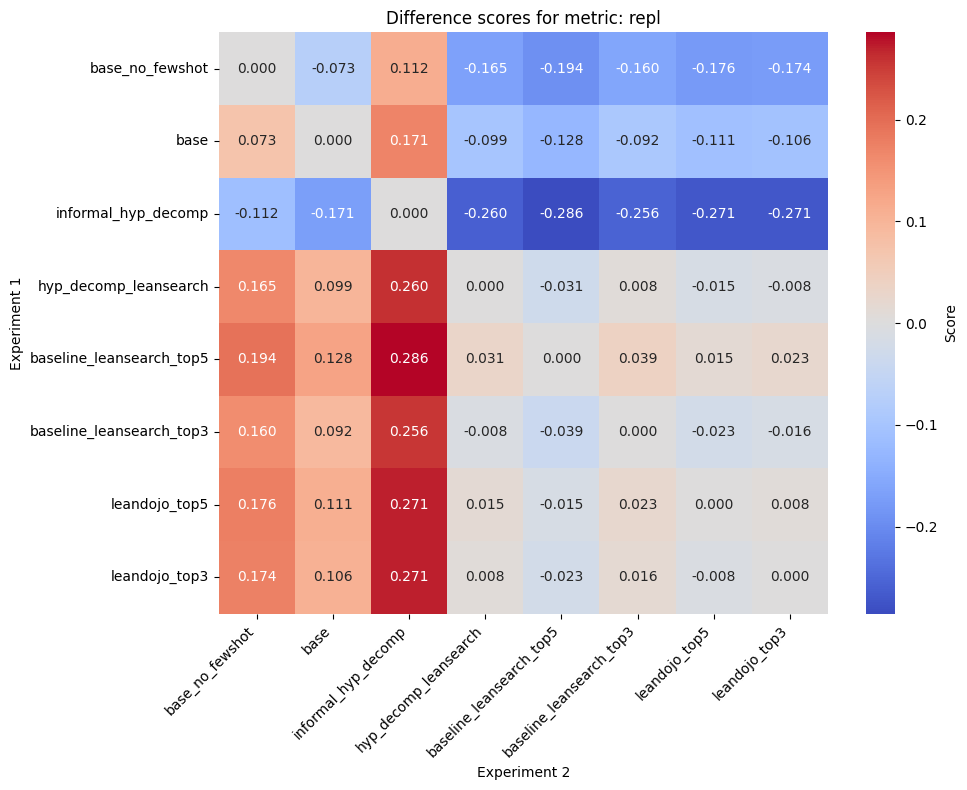

In [27]:
create_heatmap('repl', experiments)

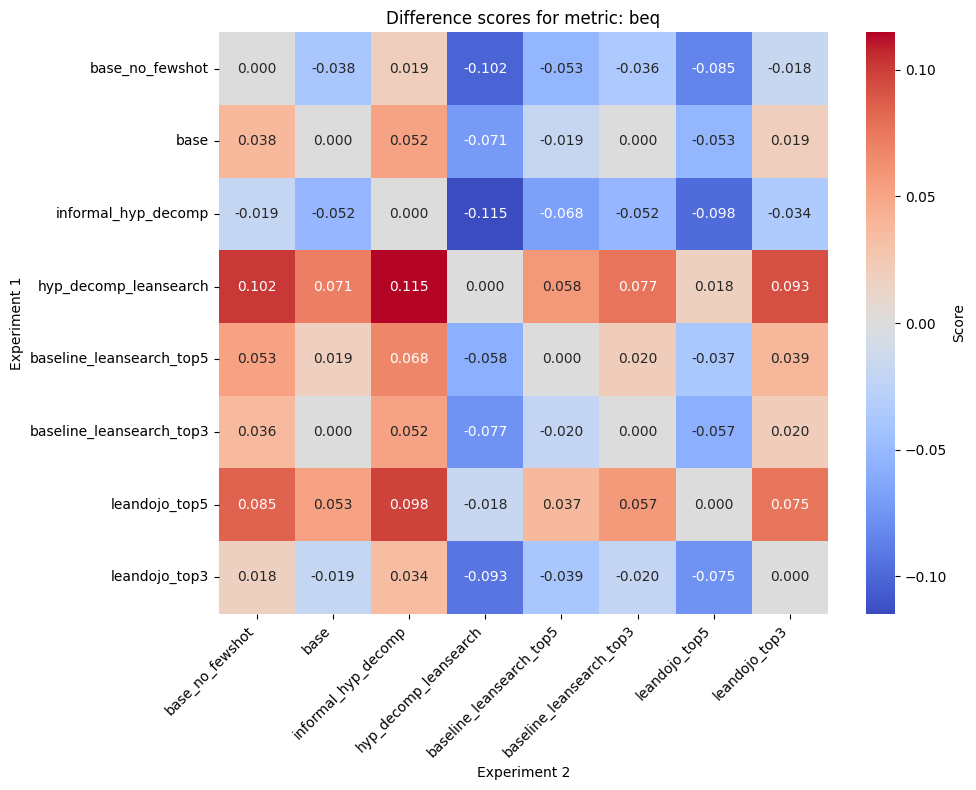

In [28]:
create_heatmap('beq', experiments)

## Alt: pos heatmaps (U1+U2)

In [ ]:
raise Exception("Stop here")

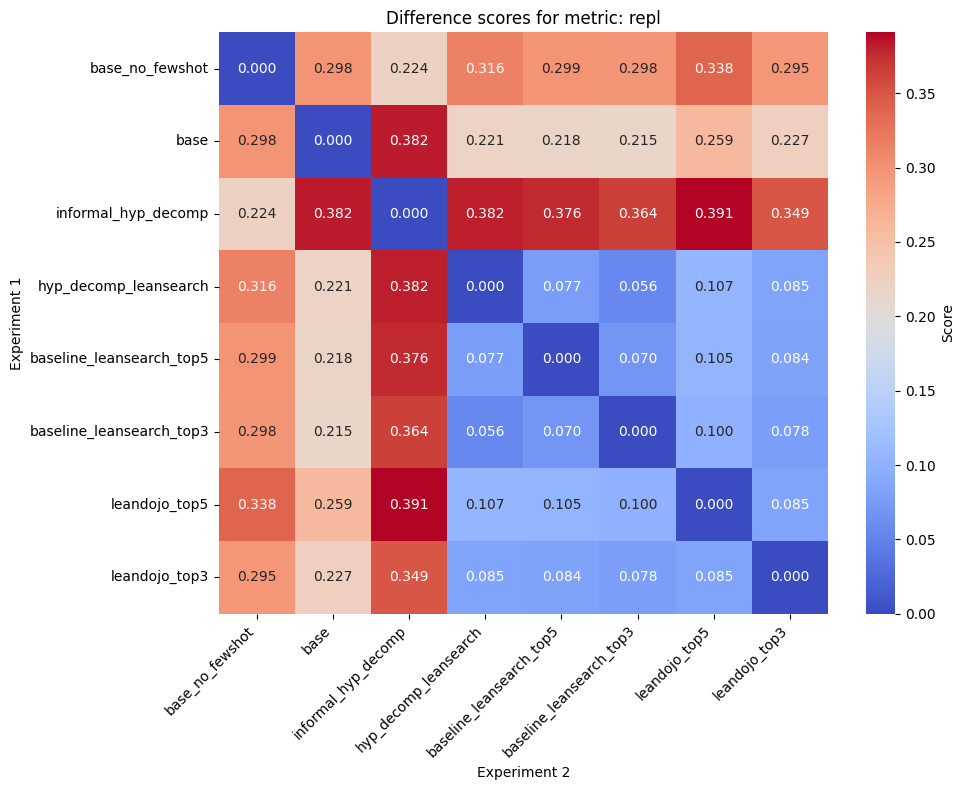

In [20]:
create_heatmap('repl', experiments)

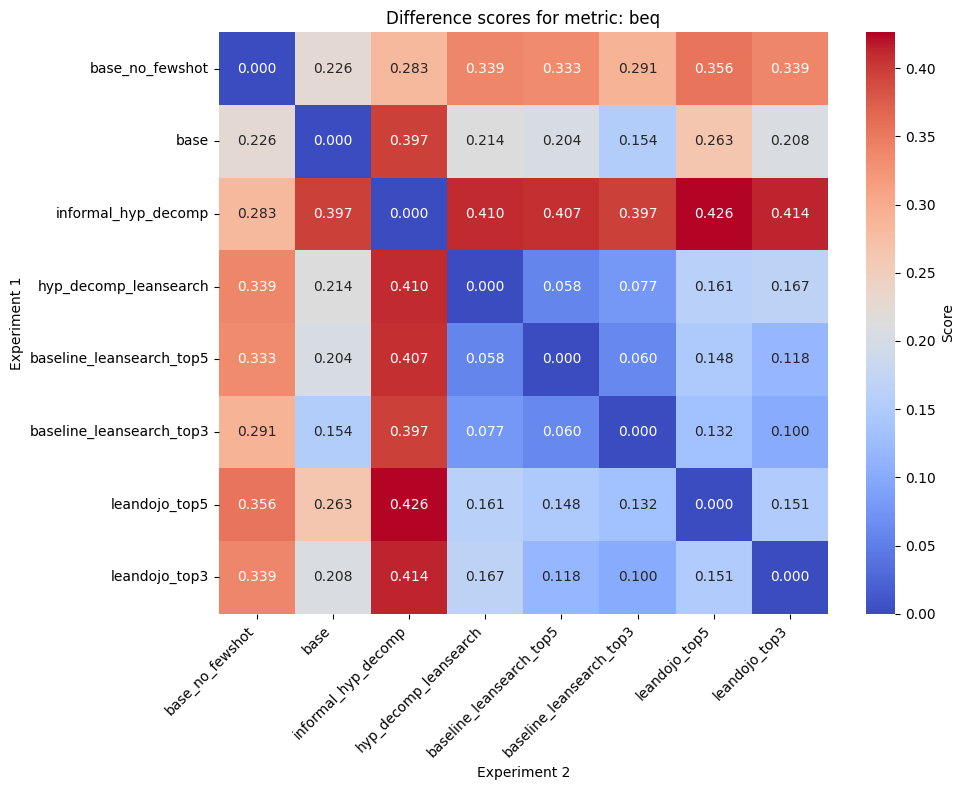

In [21]:
create_heatmap('beq', experiments)

## Bonus: Eval on abstract algebra (FAIL)

In [22]:
experiments = [
    "ADV_baseline_leansearch_top3_gpt-4o-2024-11-20_eval2",
    "ADV_baseline_leansearch_top5_gpt-4o-2024-11-20_eval2",
    "ADV_hyp_decomp_leansearch_gpt-4o-2024-11-20_eval2",
    "ADV_direct_translation_with_general_fewshot_gpt-4o-2024-11-20_eval2"
    ]

for experiment in experiments:
    print(f"Experiment: {experiment}")
    df = load_data(experiment)
    stats(df)

Experiment: ADV_baseline_leansearch_top3_gpt-4o-2024-11-20_eval2
Average TC-BLEU score: 0.065
Number of statements that type ckeck: 6 / 25 : 24.00%
Number of equivalent (BEq) pairs: 0 / 25 : 0.00%

Experiment: ADV_baseline_leansearch_top5_gpt-4o-2024-11-20_eval2
Average TC-BLEU score: 0.083
Number of statements that type ckeck: 8 / 25 : 32.00%
Number of equivalent (BEq) pairs: 0 / 25 : 0.00%

Experiment: ADV_hyp_decomp_leansearch_gpt-4o-2024-11-20_eval2
Average TC-BLEU score: 0.069
Number of statements that type ckeck: 7 / 25 : 28.00%
Number of equivalent (BEq) pairs: 0 / 25 : 0.00%

Experiment: ADV_direct_translation_with_general_fewshot_gpt-4o-2024-11-20_eval2
Average TC-BLEU score: 0.076
Number of statements that type ckeck: 7 / 25 : 28.00%
Number of equivalent (BEq) pairs: 0 / 25 : 0.00%

